<a href="https://colab.research.google.com/github/moerezapa/Stock-Price-with-Sentiment-Forecasting/blob/main/TESIS_ZAP_EnsembleLearningGARNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Library And Dataset

In [ ]:
# yah buat gitu pokoknya
import pandas as pd

# buat structuring data
import numpy as np
from numpy import hstack, vstack, asarray
from numpy.random import randint, rand

# buat ngitung execution running time
import time

# visualizating
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

# for rounding value
import math
# for square root
from math import sqrt

# splitting data
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# feature scaling
from sklearn.preprocessing import MinMaxScaler
# mse measuring
from sklearn.metrics import mean_squared_error

# merging dataframe
from functools import reduce

# rnn library
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
from keras.utils.vis_utils import plot_model # visualize model

# meta learner library
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
# load stock data (main)
dataset_stock = pd.read_csv("/content/drive/My Drive/Business/KULIAH/THESIS/Dataset/Data Historis Jakarta Stock Exchange Composite.csv")
# load stock data (for comparison)
dataset_stock_comparison1 = pd.read_csv("/content/drive/My Drive/Business/KULIAH/THESIS/Dataset/Data Historis KOSPI.csv")
dataset_stock_comparison2 = pd.read_csv("/content/drive/My Drive/Business/KULIAH/THESIS/Dataset/Data Historis Shanghai Shenzhen CSI 300.csv")
dataset_stock_comparison3 = pd.read_csv("/content/drive/My Drive/Business/KULIAH/THESIS/Dataset/Data Historis Futures S&P 500.csv")

# load sentiment data
  # coming soon ehehe

dataset_stock

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,30/06/2021,"5.985,49","5.950,43","6.011,26","5.950,42","20,32B","0,61%"
1,29/06/2021,"5.949,05","5.944,24","5.992,86","5.913,59","18,88B","0,16%"
2,28/06/2021,"5.939,47","6.015,28","6.030,89","5.939,47","14,58B","-1,38%"
3,25/06/2021,"6.022,40","6.027,22","6.067,79","6.019,40","17,24B","0,17%"
4,24/06/2021,"6.012,06","6.052,08","6.060,49","6.003,20","16,85B","-0,37%"
...,...,...,...,...,...,...,...
1202,14/07/2016,"5.083,54","5.125,69","5.131,03","5.081,03","5,26B","-0,98%"
1203,13/07/2016,"5.133,93","5.112,99","5.133,93","5.090,59","5,88B","0,67%"
1204,12/07/2016,"5.099,53","5.092,16","5.120,13","5.075,56","5,83B","0,60%"
1205,11/07/2016,"5.069,02","5.021,24","5.080,30","5.018,40","4,29B","1,96%"


# Important Function

In [ ]:
def visualizeLineChart(dataset, title):
  x_axis = dataset.columns[0]
  y_axis = dataset.columns[1]
  fig = px.line(
          dataset , 
          x= x_axis , y= y_axis, 
          title= title
        )
  fig.update_layout(
      xaxis_title= x_axis,
      yaxis_title= 'Harga Saham',
      font=dict(
          family="Montserrat",
          size=12,
          color="#000000"
      ),
      plot_bgcolor='rgba(0,0,0,0)'
  )
  fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
  fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
  fig.show()

def visualizeBarChart(dataset, titleChart):
  x_axis = dataset.columns[0]
  y_axis = dataset.columns[1]
  fig = px.bar(dataset, x= x_axis, y= y_axis, text= y_axis)
  fig.update_layout(title_text= titleChart)
  fig.show()

In [ ]:
def getInputOutput(data, n_timestep):
  input, output = [] , []
  
  for i in range(n_timestep, len(data)): 
    input.append(data[(i-n_timestep):i,:])
    output.append(data[i,0]) # 0 soalnya harga saham penutupan ada di baris pertama
  
  input, output = np.array(input), np.array(output)
  return (input, output)

In [ ]:
# objective function
def onemax(x):
	return -sum(x)
 
# tournament selection
def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]
 
# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]
 
# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]
 
# GA function
def GA(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
	# initial population of random bitstring
	pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
	# keep track of best solution
	best, best_eval = 0, objective(pop[0])
	# enumerate generations
	for gen in range(n_iter):
		# evaluate all candidates in the population
		scores = [objective(c) for c in pop]
		# check for new best solution
		for i in range(n_pop):
			if scores[i] < best_eval:
				best, best_eval = pop[i], scores[i]
				print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
		# select parents
		selected = [selection(pop, scores) for _ in range(n_pop)]
		# create the next generation
		children = list()
		for i in range(0, n_pop, 2):
			# get selected parents in pairs
			p1, p2 = selected[i], selected[i+1]
			# crossover and mutation
			for c in crossover(p1, p2, r_cross):
				# mutation
				mutation(c, r_mut)
				# store for next generation
				children.append(c)
		# replace population
		pop = children
	return [best, best_eval]

In [ ]:
def get_out_of_fold_predictions(X, y, models, timeseriesCV):
	meta_X, meta_y = list(), list()
	# define split of data
  # tscv = TimeSeriesSplit(n_splits= 5)
	# enumerate splits
	for train_ix, test_ix in timeseriesCV.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

In [ ]:
# make predictions with super learner model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)

# Exploratory Data Analysis

---

## 1.1 Data Overview

In [ ]:
# configuring  data
dataset_stock = dataset_stock[::-1] # reverse from bottom
dataset_stock = dataset_stock.reset_index(drop=True) # drop index column
dataset_stock.index = dataset_stock.index + 1 # start index from 1
# dataset_stock.columns = ['Date', 'Close','Pembu', 'MEDC_stock', 'INAF_stock']
dataset_stock.head(10)

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
1,01/07/2016,"4.971,58","5.027,62","5.039,69","4.971,58","4,05B","-0,90%"
2,11/07/2016,"5.069,02","5.021,24","5.080,30","5.018,40","4,29B","1,96%"
3,12/07/2016,"5.099,53","5.092,16","5.120,13","5.075,56","5,83B","0,60%"
4,13/07/2016,"5.133,93","5.112,99","5.133,93","5.090,59","5,88B","0,67%"
5,14/07/2016,"5.083,54","5.125,69","5.131,03","5.081,03","5,26B","-0,98%"
6,15/07/2016,"5.110,18","5.090,25","5.130,34","5.090,25","4,99B","0,52%"
7,18/07/2016,"5.127,50","5.107,92","5.131,70","5.093,15","4,92B","0,34%"
8,19/07/2016,"5.172,83","5.132,90","5.193,90","5.132,90","5,22B","0,88%"
9,20/07/2016,"5.242,82","5.185,59","5.242,82","5.185,59","5,11B","1,35%"
10,21/07/2016,"5.216,97","5.246,30","5.268,87","5.213,99","6,32B","-0,49%"


In [ ]:
dataset_stock.describe()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
count,1207,1207,1207,1207,1207,1207,1207
unique,1207,1203,1203,1200,1197,789,380
top,10/09/2019,"6.209,12","5.857,72","6.394,45","5.924,37","5,14B","-0,16%"
freq,1,2,2,2,2,6,15


In [ ]:
dataset_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 1 to 1207
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     1207 non-null   object
 1   Terakhir    1207 non-null   object
 2   Pembukaan   1207 non-null   object
 3   Tertinggi   1207 non-null   object
 4   Terendah    1207 non-null   object
 5   Vol.        1207 non-null   object
 6   Perubahan%  1207 non-null   object
dtypes: object(7)
memory usage: 66.1+ KB


In [ ]:
# remove 'B' character on 'Vol.'
d = {'K': 1000, 'M': 1000000, 'B': 1000000000}
dataset_stock['Vol.'] = dataset_stock['Vol.'].str.replace(r'\,', '.')
dataset_stock['Vol.'] = dataset_stock['Vol.'].str[:-1].astype(float) * dataset_stock['Vol.'].str[-1].replace(d)

dataset_stock

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
1,01/07/2016,"4.971,58","5.027,62","5.039,69","4.971,58",4.050000e+09,"-0,90%"
2,11/07/2016,"5.069,02","5.021,24","5.080,30","5.018,40",4.290000e+09,"1,96%"
3,12/07/2016,"5.099,53","5.092,16","5.120,13","5.075,56",5.830000e+09,"0,60%"
4,13/07/2016,"5.133,93","5.112,99","5.133,93","5.090,59",5.880000e+09,"0,67%"
5,14/07/2016,"5.083,54","5.125,69","5.131,03","5.081,03",5.260000e+09,"-0,98%"
...,...,...,...,...,...,...,...
1203,24/06/2021,"6.012,06","6.052,08","6.060,49","6.003,20",1.685000e+10,"-0,37%"
1204,25/06/2021,"6.022,40","6.027,22","6.067,79","6.019,40",1.724000e+10,"0,17%"
1205,28/06/2021,"5.939,47","6.015,28","6.030,89","5.939,47",1.458000e+10,"-1,38%"
1206,29/06/2021,"5.949,05","5.944,24","5.992,86","5.913,59",1.888000e+10,"0,16%"


In [ ]:
# convert column data type on each price's column and 'Perubahan%'
columns_to_convert = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Perubahan%']
for column in columns_to_convert:
  if column != columns_to_convert[-1]:
    dataset_stock[column] = dataset_stock[column].str.replace(r'\.', '') # ngubah 5.000 jadi 5000
  else:
    dataset_stock[column] = dataset_stock[column].str.replace(r'\%', '') # remove '%' character on 'Perubahan%'
  dataset_stock[column] = dataset_stock[column].str.replace(r'\,', '.').astype('float64') # ngubah 50,5 jadi 50.5
dataset_stock

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
1,01/07/2016,4971.58,5027.62,5039.69,4971.58,4.050000e+09,-0.90
2,11/07/2016,5069.02,5021.24,5080.30,5018.40,4.290000e+09,1.96
3,12/07/2016,5099.53,5092.16,5120.13,5075.56,5.830000e+09,0.60
4,13/07/2016,5133.93,5112.99,5133.93,5090.59,5.880000e+09,0.67
5,14/07/2016,5083.54,5125.69,5131.03,5081.03,5.260000e+09,-0.98
...,...,...,...,...,...,...,...
1203,24/06/2021,6012.06,6052.08,6060.49,6003.20,1.685000e+10,-0.37
1204,25/06/2021,6022.40,6027.22,6067.79,6019.40,1.724000e+10,0.17
1205,28/06/2021,5939.47,6015.28,6030.89,5939.47,1.458000e+10,-1.38
1206,29/06/2021,5949.05,5944.24,5992.86,5913.59,1.888000e+10,0.16


In [ ]:
# check again the data types
dataset_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 1 to 1207
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tanggal     1207 non-null   object 
 1   Terakhir    1207 non-null   float64
 2   Pembukaan   1207 non-null   float64
 3   Tertinggi   1207 non-null   float64
 4   Terendah    1207 non-null   float64
 5   Vol.        1207 non-null   float64
 6   Perubahan%  1207 non-null   float64
dtypes: float64(6), object(1)
memory usage: 66.1+ KB


In [ ]:
# check again if any missing values
dataset_stock[dataset_stock.isnull().any(axis=1)]

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%


## 1.2. Visualization

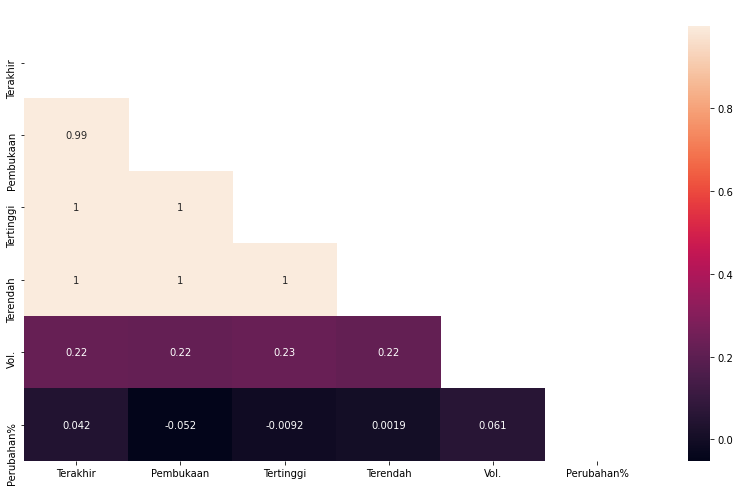

In [ ]:
feature_stock = dataset_stock.drop(columns= 'Tanggal')

plt.figure(figsize = (14,8))
title_obj = plt.title('Korelasi Tiap Feature', size = 18)
plt.setp(title_obj, color='white')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(feature_stock.corr(), dtype=np.bool))

sns.heatmap(
          feature_stock.corr(),
          mask = mask,
          annot = True
        )

plt.show()

*   Korelasi 'Perubahan%' terhadap harga saham saat penutupan korelasinya cukup rendah karena mendekati 0 (?)
*   'Pembukaan' korelasinya cukup tinggi, sekitar 0.99. Bahkan variabel 'Tertinggi' sama 'Terendah' nilai korelasinya sama dengan 1



In [ ]:
fig = px.line(
        dataset_stock , 
        x= dataset_stock.columns[0], y= dataset_stock.columns[1],
      )
fig.update_layout(
    xaxis_title="Tanggal",
    yaxis_title="Harga Saham",
    font=dict(
        family="Montserrat",
        size=12,
        color="#000000"
    ),
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes( showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

# Feature Engineering

---

## 2.1. Feature Selection and Feature Extraction

### 2.1.1. Historical Data

In [ ]:
dataset = dataset_stock[['Tanggal','Terakhir']].copy()
dataset

,Tanggal,Terakhir
1,01/07/2016,4971.58
2,11/07/2016,5069.02
3,12/07/2016,5099.53
4,13/07/2016,5133.93
5,14/07/2016,5083.54
...,...,...
1203,24/06/2021,6012.06
1204,25/06/2021,6022.40
1205,28/06/2021,5939.47
1206,29/06/2021,5949.05


### 2.1.2. Technical Indicators - MACD

In [ ]:
# calculate short term line
days_MACD_shortline = 12
dataset['days_MACD_shortline'] = dataset['Terakhir'].transform(lambda x: x.ewm(span=days_MACD_shortline, adjust=False).mean()) # calculate short term (?)

# calculate long term line
days_MACD_longline = 26
dataset['days_MACD_longline'] = dataset['Terakhir'].transform(lambda x: x.ewm(span=days_MACD_longline, adjust=False).mean()) # calculate long term (?)
dataset['MACD'] = dataset['days_MACD_longline'] - dataset['days_MACD_shortline']
dataset = dataset.drop(columns= ['days_MACD_shortline', 'days_MACD_longline'])
dataset

,Tanggal,Terakhir,MACD
1,01/07/2016,4971.58,0.000000
2,11/07/2016,5069.02,-7.772991
3,12/07/2016,5099.53,-16.208207
4,13/07/2016,5133.93,-25.376445
5,14/07/2016,5083.54,-28.250632
...,...,...,...
1203,24/06/2021,6012.06,-21.281611
1204,25/06/2021,6022.40,-18.623156
1205,28/06/2021,5939.47,-9.712591
1206,29/06/2021,5949.05,-3.384912


In [ ]:
visualizeLineChart(dataset[['Tanggal','MACD']], 'MACD difference between slow and long indicator')

### 2.1.3. Technical Indicators - RSI

In [ ]:
# define range date
days_RSI = 14
dataset['diff_price'] = dataset['Terakhir'].transform(lambda x: x.diff())
dataset = dataset.fillna(0)

# 1. calculate how many days the price is 'up'
dataset['Up'] = dataset['diff_price']
dataset.loc[(dataset['Up'] < 0), 'Up'] = 0

# 2. calculate how many days the price is 'down'
dataset['Down'] = dataset['diff_price']
dataset.loc[(dataset['Down'] > 0), 'Down'] = 0
dataset['Down'] = abs(dataset['Down'])

# 3. calculate average on each up and down
dataset['average_up'] = dataset['Up'].transform(lambda x: x.rolling(window= days_RSI).mean())
dataset['average_down'] = dataset['Down'].transform(lambda x: x.rolling(window= days_RSI).mean())

# 4. calculate RS
dataset['RS'] = dataset['average_up'] / dataset['average_down']

# 5. calculate RSI
dataset['RSI'] = 100 - (100/(1+dataset['RS']))

dataset = dataset[['Tanggal', 'Terakhir', 'MACD', 'RSI']]
dataset

,Tanggal,Terakhir,MACD,RSI
1,01/07/2016,4971.58,0.000000,NaN
2,11/07/2016,5069.02,-7.772991,NaN
3,12/07/2016,5099.53,-16.208207,NaN
4,13/07/2016,5133.93,-25.376445,NaN
5,14/07/2016,5083.54,-28.250632,NaN
...,...,...,...,...
1203,24/06/2021,6012.06,-21.281611,44.461824
1204,25/06/2021,6022.40,-18.623156,45.099575
1205,28/06/2021,5939.47,-9.712591,43.978931
1206,29/06/2021,5949.05,-3.384912,39.275208


In [ ]:
visualizeLineChart(dataset[['Tanggal','RSI']], 'RSI 14 hari')

### 2.1.4. Technical Indicators - Stochastic Oscillator (%K)

In [ ]:
days_SO = 14

# 1. get lowest and highest price on last n days
dataset['Lowest_SO'] = dataset_stock['Terendah'].transform(lambda x: x.rolling(window = days_SO).min())
dataset['High_SO'] = dataset_stock['Tertinggi'].transform(lambda x: x.rolling(window = days_SO).max())

# 2. calculate stochastic oscillator (%K)
dataset['Stochastic_K'] = ((dataset['Terakhir'] - dataset['Lowest_SO'])/(dataset['High_SO'] - dataset['Lowest_SO'])) * 100

dataset = dataset[['Tanggal', 'Terakhir', 'MACD', 'RSI', 'Stochastic_K']]
dataset

,Tanggal,Terakhir,MACD,RSI,Stochastic_K
1,01/07/2016,4971.58,0.000000,NaN,NaN
2,11/07/2016,5069.02,-7.772991,NaN,NaN
3,12/07/2016,5099.53,-16.208207,NaN,NaN
4,13/07/2016,5133.93,-25.376445,NaN,NaN
5,14/07/2016,5083.54,-28.250632,NaN,NaN
...,...,...,...,...,...
1203,24/06/2021,6012.06,-21.281611,44.461824,50.864138
1204,25/06/2021,6022.40,-18.623156,45.099575,55.000800
1205,28/06/2021,5939.47,-9.712591,43.978931,21.823492
1206,29/06/2021,5949.05,-3.384912,39.275208,25.656105


In [ ]:
visualizeLineChart(dataset[['Tanggal','Stochastic_K']], 'Stochastic 14 Hari %K')

In [ ]:
# dataset for saham is ready ehehe
dataset

,Tanggal,Terakhir,MACD,RSI,Stochastic_K
1,01/07/2016,4971.58,0.000000,NaN,NaN
2,11/07/2016,5069.02,-7.772991,NaN,NaN
3,12/07/2016,5099.53,-16.208207,NaN,NaN
4,13/07/2016,5133.93,-25.376445,NaN,NaN
5,14/07/2016,5083.54,-28.250632,NaN,NaN
...,...,...,...,...,...
1203,24/06/2021,6012.06,-21.281611,44.461824,50.864138
1204,25/06/2021,6022.40,-18.623156,45.099575,55.000800
1205,28/06/2021,5939.47,-9.712591,43.978931,21.823492
1206,29/06/2021,5949.05,-3.384912,39.275208,25.656105


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 1 to 1207
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tanggal       1207 non-null   object 
 1   Terakhir      1207 non-null   float64
 2   MACD          1207 non-null   float64
 3   RSI           1194 non-null   float64
 4   Stochastic_K  1194 non-null   float64
dtypes: float64(4), object(1)
memory usage: 47.3+ KB


jadinya ada 13 missing value

## 2.2. Analisis sentimen

# Modelling

---

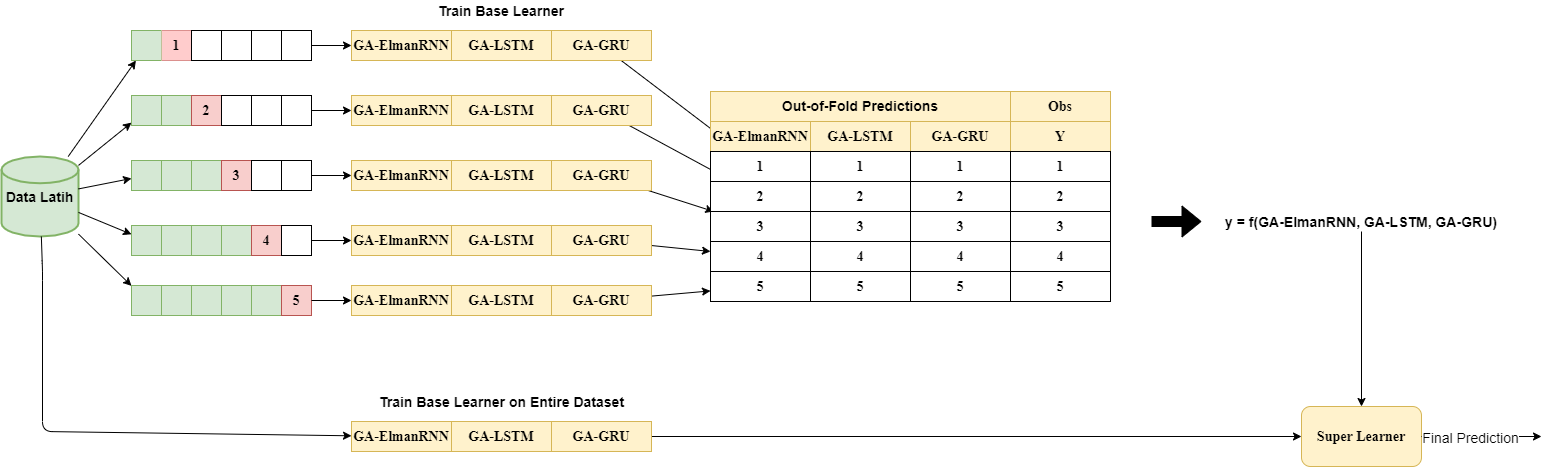

## 3.0. Preparing Dataset for Modelling

In [ ]:
dataset = dataset.dropna()

X = dataset.reset_index(drop= True).drop(columns=['Tanggal'])
y = dataset.reset_index(drop= True)['Terakhir']

# split into train:test set
X, X_test, y, y_test = train_test_split(X, y, test_size=0.30, shuffle = False)
print('Train', X.shape, y.shape, 'Test', X_test.shape, y_test.shape)

# feature scaling
stock_normalizer, nonstock_normalizer = MinMaxScaler(feature_range= (0,1)) , MinMaxScaler(feature_range= (0,1))
X_normalized_stock = stock_normalizer.fit_transform(X[['Terakhir']])
X_normalized_nonstock = nonstock_normalizer.fit_transform(X.drop(columns=['Terakhir']))

# combine features by horizontally
features_input_train = hstack((X_normalized_stock, X_normalized_nonstock))

X_train, y_train = getInputOutput(data= features_input_train, n_timestep= 5)

Train (835, 4) (835,) Test (359, 4) (359,)


In [ ]:
for i in range(len(X_train)):
	print(X_train[i], y_train[i])

[[0.14844817 0.19924477 0.84266777 0.91654306]
 [0.16340373 0.18086493 0.85430869 0.99040666]
 [0.11331917 0.19531888 0.64115791 0.54312345]
 [0.20094006 0.16494828 0.72368098 0.97677738]
 [0.20800559 0.14097847 0.70994401 0.95666547]] 0.19510228154959997
[[0.16340373 0.18086493 0.85430869 0.99040666]
 [0.11331917 0.19531888 0.64115791 0.54312345]
 [0.20094006 0.16494828 0.72368098 0.97677738]
 [0.20800559 0.14097847 0.70994401 0.95666547]
 [0.19510228 0.13250319 0.75466149 0.88296041]] 0.20833057493124052
[[0.11331917 0.19531888 0.64115791 0.54312345]
 [0.20094006 0.16494828 0.72368098 0.97677738]
 [0.20800559 0.14097847 0.70994401 0.95666547]
 [0.19510228 0.13250319 0.75466149 0.88296041]
 [0.20833057 0.12290765 0.75192411 0.9468731 ]] 0.23624961633134545
[[0.20094006 0.16494828 0.72368098 0.97677738]
 [0.20800559 0.14097847 0.70994401 0.95666547]
 [0.19510228 0.13250319 0.75466149 0.88296041]
 [0.20833057 0.12290765 0.75192411 0.9468731 ]
 [0.23624962 0.105035   0.76829779 0.9753241

In [ ]:
# make data structure which is consist of all data testing + last n row of data training
input_for_out_of_sample = dataset[len(dataset) - len(X_test) - 5:]
input_for_out_of_sample = input_for_out_of_sample.reset_index(drop=True) # drop index column
input_for_out_of_sample.index = input_for_out_of_sample.index + 1 # start index from 1
input_for_out_of_sample = input_for_out_of_sample.drop(columns= 'Tanggal')
input_for_out_of_sample

,Terakhir,MACD,RSI,Stochastic_K
1,6329.31,-46.278721,74.568093,95.943215
2,6299.54,-46.430609,65.840902,80.903304
3,6283.58,-44.747323,62.311131,72.840255
4,6323.47,-46.100677,67.750526,92.992826
5,6257.40,-41.365092,58.458441,59.614024
...,...,...,...,...
360,6012.06,-21.281611,44.461824,50.864138
361,6022.40,-18.623156,45.099575,55.000800
362,5939.47,-9.712591,43.978931,21.823492
363,5949.05,-3.384912,39.275208,25.656105


In [ ]:
# data testing normalization
X_test_normalized_stock = stock_normalizer.transform(input_for_out_of_sample[['Terakhir']])
X_test_normalized_nonstock= nonstock_normalizer.transform(input_for_out_of_sample.drop(columns=['Terakhir']))

# combine features by horizontally
features_input_test = hstack((X_test_normalized_stock, X_test_normalized_nonstock))

X_out_of_sample = []
for i in range(5, len(features_input_test)):
    X_out_of_sample.append(features_input_test[i-5:i, : ])
X_out_of_sample = np.array(X_out_of_sample)
X_out_of_sample = X_out_of_sample.reshape((X_out_of_sample.shape[0], X_out_of_sample.shape[1], input_for_out_of_sample.shape[1]))

## 3.1. Base Model

In [ ]:
# define the total iterations
n_iter = 100
# bits
n_bits = 20
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.9
# mutation rate
r_mut = 1.0 / float(n_bits)
# perform the genetic algorithm search
best, score = GA(onemax, n_bits, n_iter, n_pop, r_cross, r_mut)
print('Done!')
print('f(%s) = %f' % (best, score))

>0, new best f([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1]) = -16.000
>2, new best f([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]) = -17.000
>4, new best f([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = -19.000
>7, new best f([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = -20.000
Done!
f([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) = -20.000000


### GA-ElmanRNN

In [ ]:
# get models
...

# get out of fold predictions
meta_X_ElmanRNN, meta_y_ElmanRNN = get_out_of_fold_predictions(X_train, y_train, models)

### GA-LSTM

In [ ]:
# get models
...

# get out of fold predictions
meta_X_LSTM, meta_y_LSTM = get_out_of_fold_predictions(X_train, y_train, models)

### GA-GRU

In [ ]:
# get models
...

# get out of fold predictions
meta_X_GRU, meta_y_GRU = get_out_of_fold_predictions(X_train, y_train, models)

In [ ]:
# combine meta prediction
meta_X = hstack((meta_X_ElmanRNN, meta_X_LSTM, meta_X_GRU))
meta_y = hstack((meta_y_ElmanRNN, meta_y_LSTM, meta_y_GRU))

## 3.2. Super Learner

*   Training the meta learner on out-of-fold predictions
*   By training on out-of-fold predictions from the base model, the meta learner learn how to correct the oout of-fold predictions for each model and to best combine the out-of-fold predictions from multiple model
*   Evaluate the meta learner on new out-of-sample data which is not used to train the base model
*   List item





In [ ]:
# evaluate base models
models = [
    # masukin GA-ElmanRNN
    # masukin GA-LSTM
    # masukin GA-GRU
]
evaluate_models(X_test, y_test, models)

### 3.1.1. Random Forest as Meta Learner

In [ ]:
# fit the meta model
rf_metamodel = RandomForestRegressor()
rf_metamodel.fit(meta_X, meta_y)

In [ ]:
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
pred = super_learner_predictions(X_test, models, rf_metamodel)
pred = stock_normalizer.inverse_transform(pred) # denormalization forecast result
rmse_meta_pred = sqrt(mean_squared_error(y_val, pred))
print('RMSE of Super Learner using {0} as meta learner: {1}'.format(rf_metamodel.__class__.__name__ , rmse_meta_pred))

### 3.1.2. Linear Regression as Meta Learner

In [ ]:
# fit the meta model
lr_metamodel = LinearRegression()
lr_metamodel.fit(meta_X, meta_y)

In [ ]:
# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)
# evaluate base models
evaluate_models(X_val, y_val, models)
# evaluate meta model
pred = super_learner_predictions(X_val, models, lr_metamodel)
pred = stock_normalizer.inverse_transform(pred) # denormalization forecast result
rmse_meta_pred = sqrt(mean_squared_error(y_val, pred))
print('RMSE of Super Learner using {0} as meta learner: {1}'.format(lr_metamodel.__class__.__name__ , rmse_meta_pred))

# Model Analysis

---